# Predicting High Traffic Recipes for Tasty Bytes

## Introduction
Tasty Bytes was founded in 2020 in the midst of the Covid Pandemic. The world wanted inspiration so we decided to provide it. We started life as a search engine for recipes, helping people to find ways to use up the limited supplies they had at home.

Currently, the Product Manager is responsible for selecting and displaying recipe on the home page of the website. The have noticed that traffic to the rest of the website goes up by as much 40% if the recipe is popular. However, it is difficult to determine if a recipe will lead to high traffic. 

The company wants to use a data driven approach to predict recipes that will be popular 80% of the time and minimize the chance of showing unpopular recipes.

## Data Validation and Cleaning

The dataset provided contains 947 features and 8 columns. The validation and cleaning process applied to each column are listed below:
- recipe: just as described in the data dictionary, no cleaning needed.
- calories: contains 895 non-null and 52 null values, the null values were dropped
- carbohydrate: contains 895 non-null and 52 null values, the null values were dropped
- sugar: contains 895 non-null and 52 null values, the null values were dropped
- protein: contains 895 non-null and 52 null values, the null values were dropped
- category: contains 11 unique categories instead of 10, chicken breast was recoded as chicken
- servings: Numeric indicating the number of servings. Some enries included text(e.g, "4 as a snack"); the numeric part was extracted and converted to integers
- high_traffic: Target variable, marked as "High" for high traffic or "NA" otherwise. High was mapped to 1, and "NA" to 0, treating "NA" as low traffic 

In [3]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import precision_score, accuracy_score 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier

In [4]:
# Reading the data into a dataframe and displaying the first 5 rows
df = pd.read_csv('recipe_site_traffic_2212.csv')
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [5]:
# Inspecting the shape and data type of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [6]:
# Droping missing values from dataframe
cols_check =['calories', 'carbohydrate', 'sugar', 'protein']
df.dropna(subset = cols_check, inplace = True)

In [7]:
# Checking for duplicate rows
df.duplicated().sum()

0

In [8]:
# Inspecting the uniques values from the category column
df['category'].value_counts()

Breakfast         106
Chicken Breast     94
Beverages          92
Potato             83
Lunch/Snacks       82
Vegetable          78
Dessert            77
Meat               74
Pork               73
Chicken            69
One Dish Meal      67
Name: category, dtype: int64

In [9]:
# Cleaning and validating category column
df['category'].replace({'Chicken Breast': 'Chicken'}, inplace = True)

In [10]:
# Inspecting the uniques values from the servings column
df['servings'].value_counts()

4               365
6               184
2               174
1               169
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64

In [11]:
# Cleaning and validating servings column
df['servings'].replace({'4 as a snack': '4', '6 as a snack': '6'}, inplace =True)
df['servings'] = df['servings'].astype('int')

In [12]:
# Cleaning and validating high_traffic column
df['high_traffic'].replace({'High': '1'}, inplace = True)
df['high_traffic'].fillna('0', inplace = True)
df['high_traffic'] = df['high_traffic'].astype(int)

In [13]:
df.describe()

,recipe,calories,carbohydrate,sugar,protein,servings,high_traffic
count,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000
mean,473.652514,435.939196,35.069676,9.046547,24.149296,3.458101,0.597765
std,272.763283,453.020997,43.949032,14.679176,36.369739,1.735979,0.490623
min,2.000000,0.140000,0.030000,0.010000,0.000000,1.000000,0.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000,2.000000,0.000000
50%,475.000000,288.550000,21.480000,4.550000,10.800000,4.000000,1.000000
75%,708.500000,597.650000,44.965000,9.800000,30.200000,4.000000,1.000000
max,947.000000,3633.160000,530.420000,148.750000,363.360000,6.000000,1.000000


# Exploratory Data Analysis

## Box Plot of Numerical Variables
The chart below shows the distribution of calories, carbohydrate, sugar, and protein of recipes with median values of 288.55, 21.48, 4.55, and 10.8 respectively. However, it is obvious that the numerical variables contain outliers to the right of the distribution

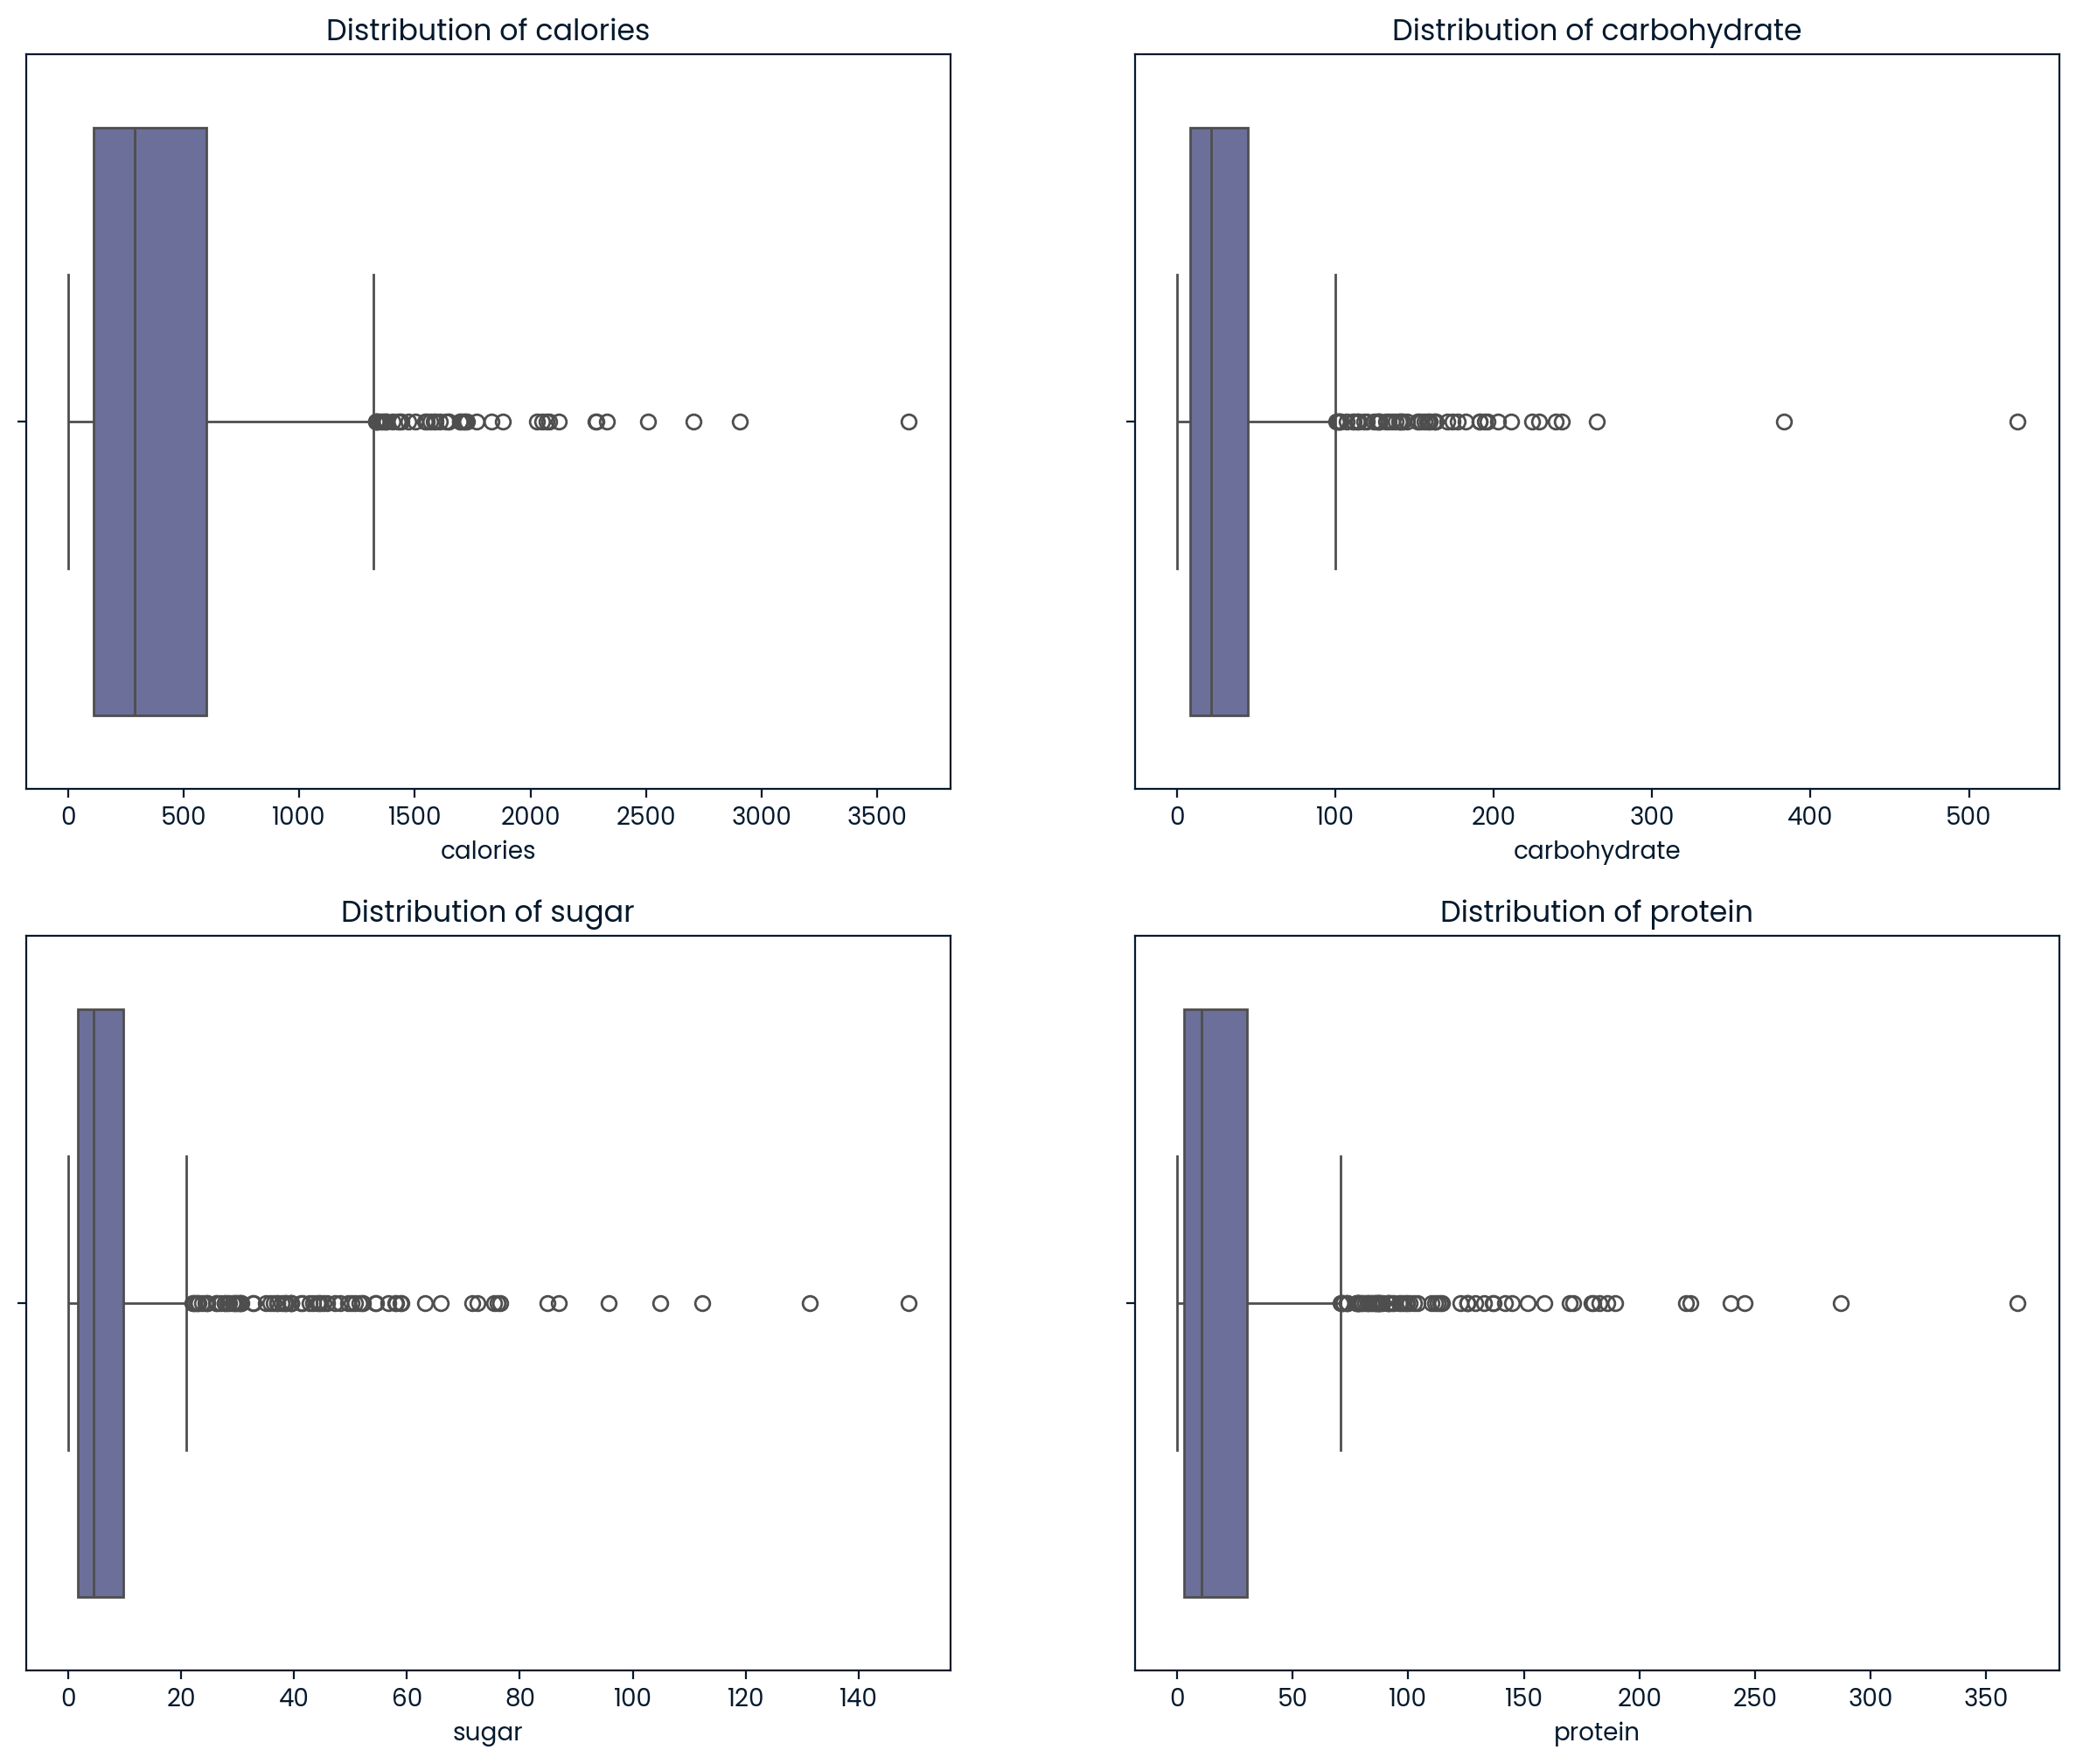

In [14]:
fig, axes = plt.subplots(2, 2, figsize = (15,12))
cols = ['calories', 'carbohydrate', 'sugar', 'protein']
# Flatten the 2D axes array to iterate easily
axes = axes.flatten()

for idx, col in enumerate(cols):
    sns.boxplot(data=df, x=col, ax=axes[idx])
    axes[idx].set_title(f"Distribution of {col}")

## Distribution of High Traffic
A bar plot showed approximately 60% of recipes (535) led to high traffic, indicating a moderately balanced dataset.

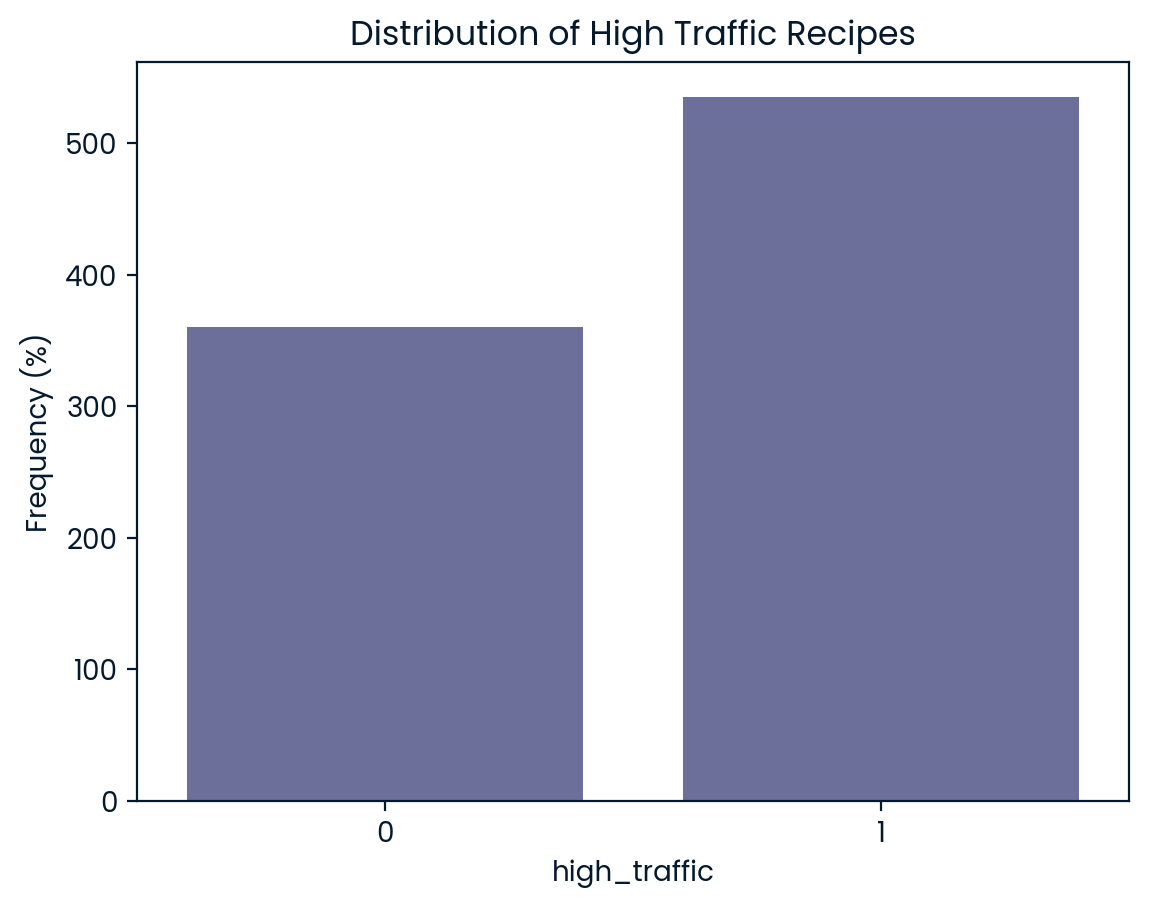

In [15]:
sns.countplot(data = df, x = 'high_traffic')
plt.title('Distribution of High Traffic Recipes')
plt.ylabel('Frequency (%)');

## Category Distribution
The bar chart shows the distribution of recipes by their category. It shows that Chicken is the most frequent recipe followed by Breakfast, and Beverages

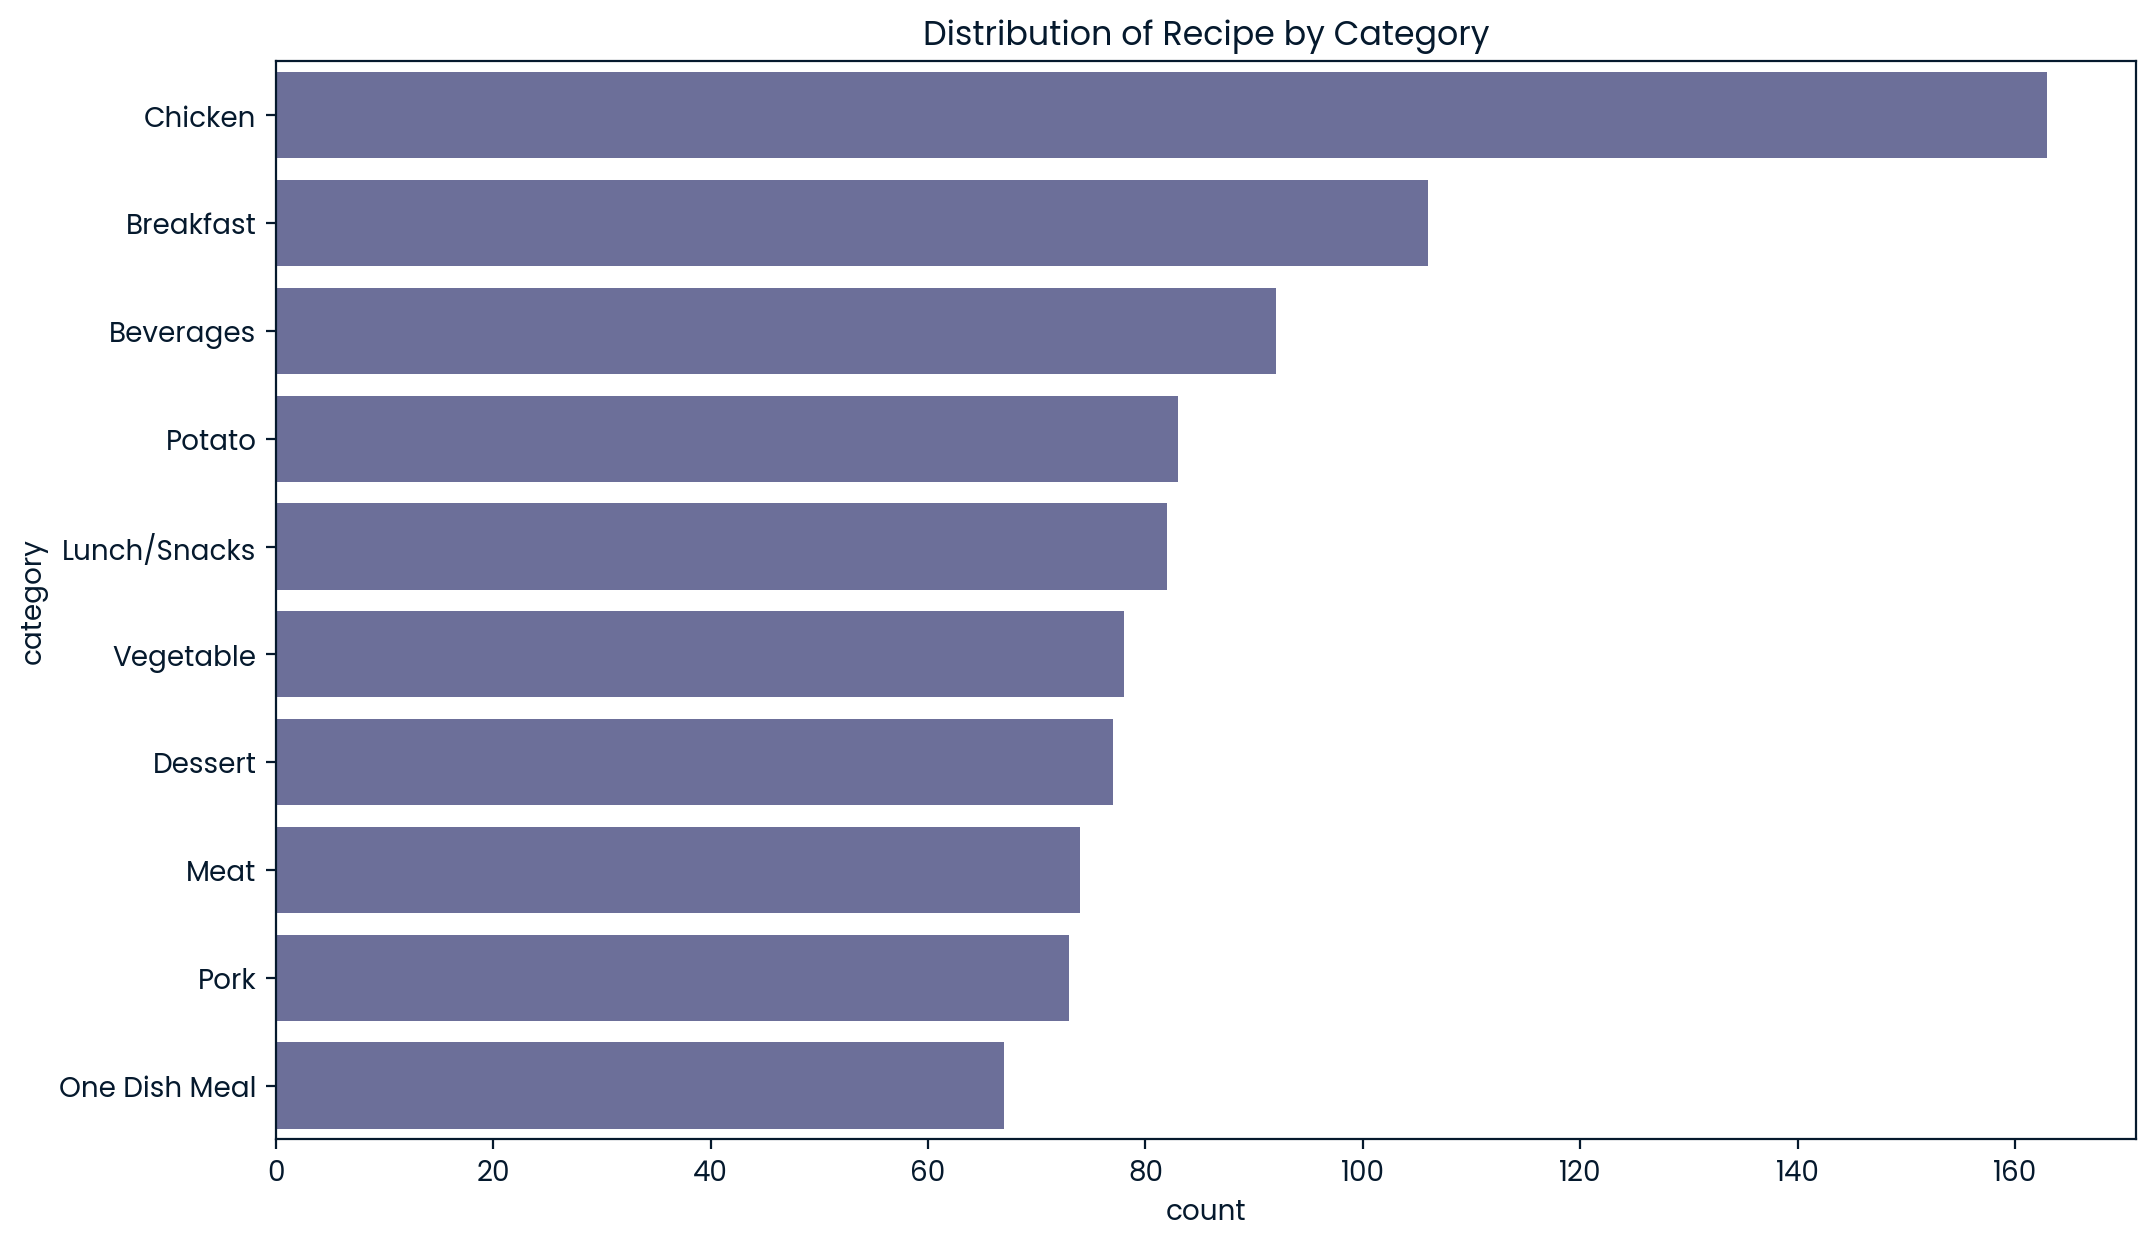

In [16]:
fig, axes = plt.subplots(1, 1, figsize = (12,7))
# Sorting categories by count in descending order
category_order = df['category'].value_counts().index
sns.countplot(data = df, y = 'category', ax= axes, order = category_order)
plt.title('Distribution of Recipe by Category');

## Correlation Heatmap
The correlation heatmap between the numerical variables indicate that there is a very low positive linear relationship between the pairs of calories and protein

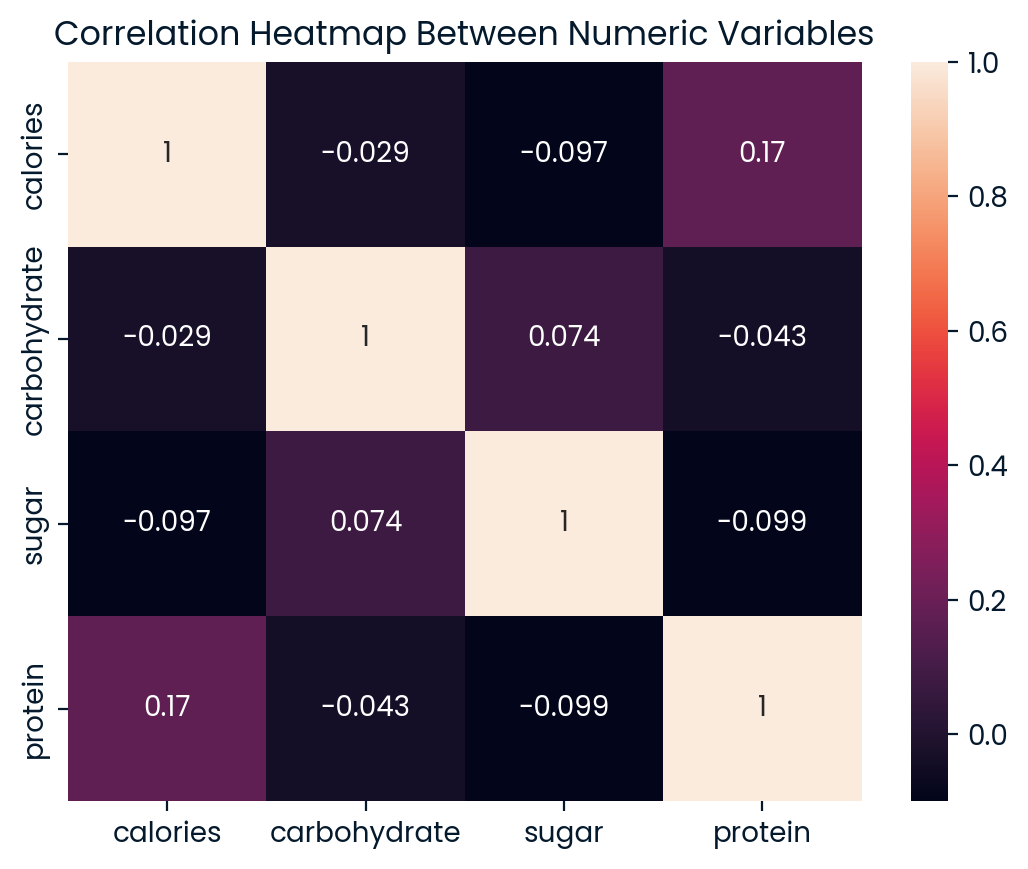

In [17]:
sns.heatmap(df[cols].corr(), annot = True);
plt.title('Correlation Heatmap Between Numeric Variables');

## High Traffic Proportion By Category
The stacked bar chart shows that 99% of Vegetable, 94% of Potato, and 90% of Pork recipes lead to high traffic on the website

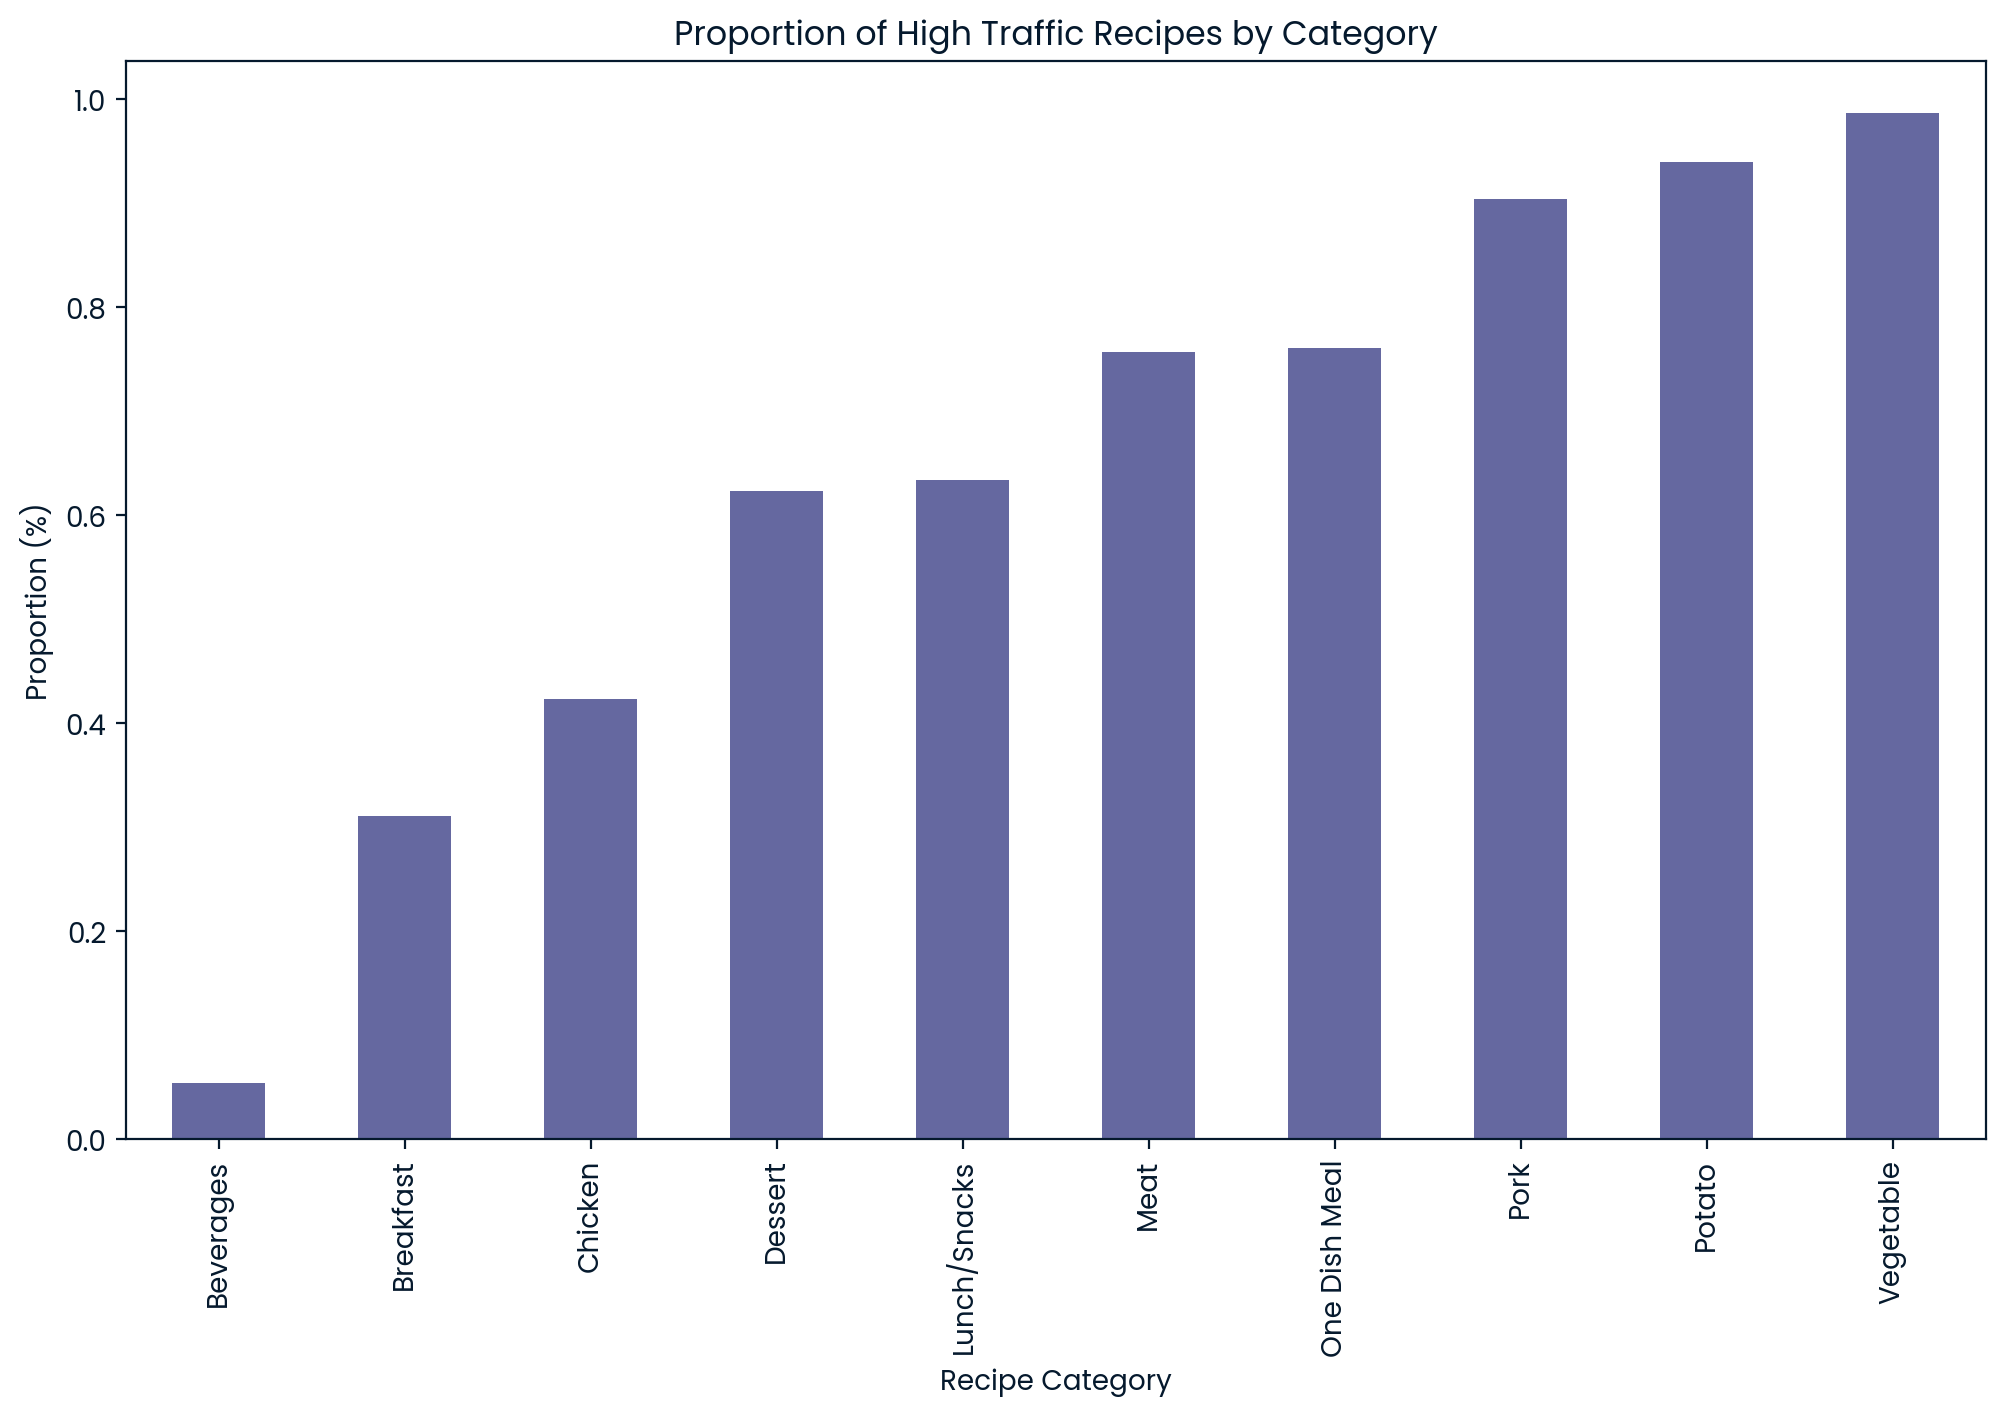

In [18]:
df_prop = df.groupby(['category'])['high_traffic'].mean().sort_values()
df_prop.plot(kind = 'bar', figsize = (12,7));
plt.title('Proportion of High Traffic Recipes by Category')
plt.xlabel('Recipe Category')
plt.ylabel('Proportion (%)');

# Model Development
Predicting if a recipe will lead to high traffic or not is a binary classification problem. I will be using a linear model (Logistic Regression) as the baseline model as it's a simple and interpretable classifier, and a tree model (Decision Tree Classifier) as the comparison model due to its ability to capture complex non-linear pattern in the training data.

## Preparing Data for Modelling
The following preprocessing steps were performed on the dataset before passing it to any model:
- Replace outlier values using a lower and upper limit values.
- Standardize numerical variables
- Apply OneHotEncoder on categorical variable
- Split the data into train set and test set

In [19]:

cols = ['calories', 'carbohydrate', 'sugar', 'protein']

for col in cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - (1.5*iqr)
    upper_limit = q3 + (1.5*iqr)
    df[col] = df[col].clip(lower_limit, upper_limit)
    

In [20]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), ['calories', 'carbohydrate', 'sugar', 'protein', 'servings']),
        ('cat', OneHotEncoder(), ['category'])
    ]
)

In [21]:
X = df.drop(columns = ['recipe', 'high_traffic'])
y = df['high_traffic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state =42)

## Fitting Logistic Regression Model

In [22]:
log_model = Pipeline([
    ('pre', preprocessor),
    ('log', LogisticRegression())
])
log_model.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['calories', 'carbohydrate',
                                                   'sugar', 'protein',
                                                   'servings']),
                                                 ('cat', OneHotEncoder(),
                                                  ['category'])])),
                ('log', LogisticRegression())])

## Fitting Decision Tree Classifier Model

In [23]:
dt_model = Pipeline([
    ('pre', preprocessor),
    ('dt', DecisionTreeClassifier(max_depth = 4, random_state=42))
])
dt_model.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['calories', 'carbohydrate',
                                                   'sugar', 'protein',
                                                   'servings']),
                                                 ('cat', OneHotEncoder(),
                                                  ['category'])])),
                ('dt', DecisionTreeClassifier(max_depth=4, random_state=42))])

# Model Evaluation
The two models was evaluated using accuracy, and precision. Accuracy is the proportion of correct predictions out of all predictions made on the test smaple. Precision is the proportion of positive predictions made by the model that actually belong to positive class.

In [24]:
y_pred = log_model.predict(X_test)
print(f'Logistic Regression Accuracy Score: {round(accuracy_score(y_test, y_pred)*100, 2)}%')
print(f'Logistic Regression Precision Score: {round(precision_score(y_test,y_pred)*100,2)}%')

Logistic Regression Accuracy Score: 77.65%
Logistic Regression Precision Score: 85.26%


In [25]:
y_pred = dt_model.predict(X_test)
print(f'Decision Tree Classifier Accuracy Score: {round(accuracy_score(y_test, y_pred)*100, 2)}%')
print(f'Decision Tree Classifier Precision Score: {round(precision_score(y_test, y_pred)*100, 2)}%')

Decision Tree Classifier Accuracy Score: 75.42%
Decision Tree Classifier Precision Score: 80.58%


## Comaprison
The evaluation scores above showed that Logistic Regression performed better than Decision Tree Classifier in terms of accuracy (78% vs 75%) and precision (85% vs 81%). This mean that Logistic Regression fit the data and has less error in predicting traffic of recipes

# Business Focus and Metrics
The company wants to predict recipes that will lead to traffic 80% of the time, as more traffic will lead more subscriptions and revenue. Therefore, the business KPI is to have a model that can acheive at leat 80% Precision. High precision means that when the model predicts a recipe will lead to high traffic, it is correct most of the time, reducing the chance of showing unpopular recipes.
Logistic Regression has a precision of 100%, while Decision Tree Classifier has 100% of precision. Though both model meet the criteria set by the company, however Logistic Regrssion performed better in predicting high traffic recipes and minimizing errors of showing unpopular recipes.

# Summary and Reccomendations
The exploratory analysis showed that Potato, Vegetable, and Pork recipes are most likely to drive traffic, suggesting a focus on these categories. The By deploying Logistic Regression model, which a computational efficient model, it is possible to select daily recipes that generate high traffic, with 80% confidence. Also the model should be monitored periodically to track performance. Additionaly more data (e.g., cooking time, cost) should be collected to further improve predictive accuracy